# Module 03: Assignment for 1-D Diffusion Problem - Thawing Permafrost

### 1. Introduction and Background

In this notebook you are going to investigate the impact of three climate change scenarios on our previously developed model of the vertical distribution of temperature in a permafrost soil. 


Again, the equation for 1-dimensional heat diffusion into a soil is presented below:
$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = \frac{\partial T_s}{\partial z}\left(k_s \cdot \frac{\partial T_s}{\partial z}\right)
$$

where $\rho_s$ (kg/m^3) is the bulk density of the soil, $C_s$ (J/(kg K)) is the heat capacity of the soil, $k_s$ (W/(m K)) is the thermal conductivity of the soil, $T_s$ is the temperature of the soil at some time $t$ and depth in the soil $z$. For the sake of simplicity, we're going to assume that the thermal conductivity is constant. This assumption is not strictly true, as $k_s$ changes with the amount and phase (frozen or liquid) of water in the soil. But it makes the math much simpler and is good starting point for a toy model. Under this assumption we can simplify the above equation to,

$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = k_s \frac{\partial T_s^2}{\partial^2 z}
$$

Going further, if we also assume that the bulk density ($rho_s$) and heat capacity ($C_s$) are constant, then we can combine them with the thermal conductivity and reduce them to a single parameter that is often referred to as the _thermal diffusivity_ ($D_s$) and has dimensions of m^2/s, 

$$
D_s = \frac{k_s}{\rho_s \cdot C_s}
$$

Substituting into the above, we obtain the following governing equation that our model will solve, 

$$
\frac{\partial T_s}{\partial t} = D_s \frac{\partial T_s^2}{\partial^2 z}
$$

Your __top boundary condition__, we will assume sinusoidal forcing of air temperature superimposed on a linear trend in mean annual temperatures at the surface, with a period of one year. In this notebook we will explore three scenarios. Scenario 1 is a linear increase in mean annual temperature at a rate that results in 1.5 °C of warming by 2100. Scenario 2 is a linear increase in mean annual temperature at a rate that results in 3.0 °C of warming by 2100. Scenario 3 is a linear increase in mean annual temperature at a rate that results in 4.5 °C of warming by 2100. We will start all simulations in 2020. 

Your __bottom boundary condition__, we will assume a constant temperature at the initial mean annual air temperature. 

Yur __initial condition__ will be a constant temperature (isothermal) at the mean annual air temperature. If interested you can copy this notebook and modify these values.

### 2. Initial Setup

Below, we set the values for our spatial domain, simulation period, soil properties, and boundary conditions. 

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as sparseModule
import scipy.sparse.linalg as linalgModule
import matplotlib.pyplot as plt

# Soil column properties
zs = 5.0 # Depth of soil [cm]
Nz = 50

# Soil properties (obtained from https://doi.org/10.1029/2017JF004535)
Cs = 635.0 				# Heat capacity of soil/permafrost [J/(kg K)]
ks = 0.25  				# Thermal conductivity of soil/permafrost [W/(m K)]
rhos = 920.0 			# Bulk density of permafrost [kg/m^3] 
Ds = ks / (rhos * Cs)	# Soil diffusivity [m^2/s]

# Temperature properties
mean_annual_temperature = -7.0	# [C]

# Create dictionaries for scenarios
scenarios = {}
scenarios['sim_data'] = {}		# For storing simulation info for all scenarios
scenarios['1.5C'] = {}			# For linear 1.5C increase by 2100
scenarios['3.0C'] = {}			# For linear 3.0C increase by 2100
scenarios['4.5C'] = {}			# For linear 4.5C increase by 2100

#### 2.1 Load and Plot the Air Temperature Trends

In [2]:
data = np.loadtxt('PermafrostTemperatureScenarios.csv', delimiter=',', skiprows=1)

t_year = data[:,0]
T_15 = data[:,1]
T_30 = data[:,2]
T_45 = data[:,3]

scenarios['1.5C']['t_year'] = t_year
scenarios['3.0C']['t_year'] = t_year
scenarios['4.5C']['t_year'] = t_year

scenarios['1.5C']['data'] = T_15
scenarios['3.0C']['data'] = T_30
scenarios['4.5C']['data'] = T_45

Text(0, 0.5, 'Annual average air temperature [°C]')

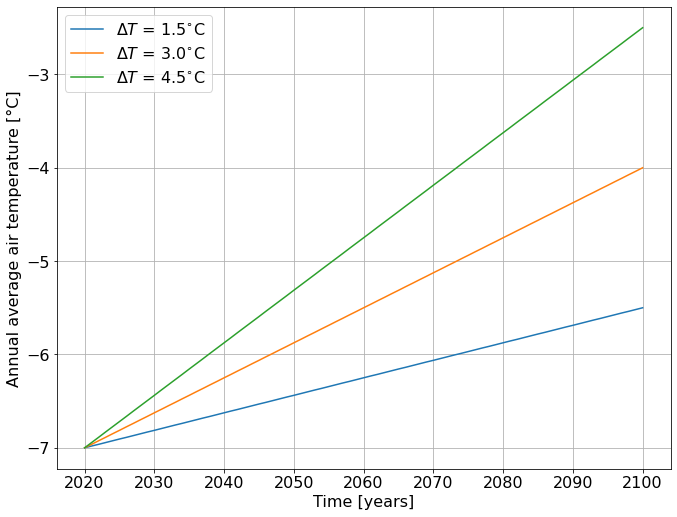

In [3]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(11.0,8.5))
plt.plot(t_year,T_15,label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t_year,T_30,label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t_year,T_45,label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Time [years]')
plt.ylabel('Annual average air temperature [°C]')

#### 2.2 Setup the Simulation Time Period

In [4]:
# Time properties of simulation
#    Time Step
DAY_TO_SEC = 86400
SEC_TO_DAY = 1/DAY_TO_SEC
YEAR_TO_SEC = 31556952
SEC_TO_YEAR = 1/YEAR_TO_SEC
dt_day = 0.25 # Time step [day]
dt = dt_day * DAY_TO_SEC
dt_year = dt * SEC_TO_YEAR

#    Time domain
t0 = t_year[0]
tf = t_year[-1]
t = np.arange(t0,tf+dt_year,dt_year)
Nt = t.size
print('The number of time steps: Nt = ',str(Nt))

scenarios['sim_data']['t_initial'] = t0
scenarios['sim_data']['t_final'] = tf
scenarios['sim_data']['time_steps'] = t
scenarios['sim_data']['Nt'] = Nt
scenarios['sim_data']['dt'] = dt

The number of time steps: Nt =  116879


### 3. Setup Boundary Conditions

In [5]:
# Boundary conditions
Ttopamp = 35.0
Tbottom = mean_annual_temperature

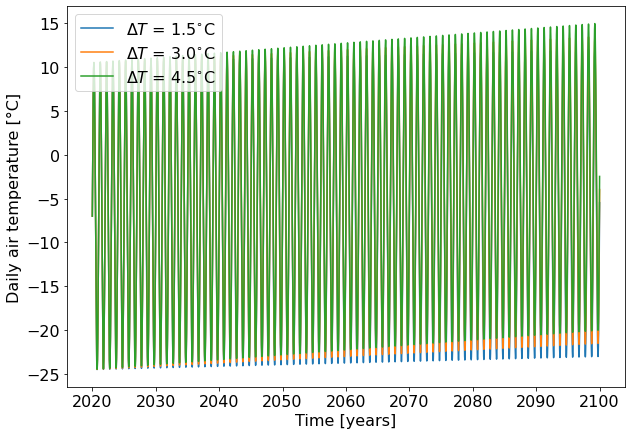

In [6]:
Ttop_15 = np.interp(t, t_year, T_15) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_30 = np.interp(t, t_year, T_30) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_45 = np.interp(t, t_year, T_45) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)

scenarios['1.5C']['top_BC_data'] = Ttop_15
scenarios['3.0C']['top_BC_data'] = Ttop_30
scenarios['4.5C']['top_BC_data'] = Ttop_45

scenarios['1.5C']['bottom_BC_data'] = Tbottom
scenarios['3.0C']['bottom_BC_data'] = Tbottom
scenarios['4.5C']['bottom_BC_data'] = Tbottom

plt.figure(figsize=(10.0,7.0))
plt.plot(t, Ttop_15, label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t, Ttop_30, label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t, Ttop_45, label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.xlabel('Time [years]')
plt.ylabel('Daily air temperature [°C]')
plt.legend(loc='upper left')
plt.show()

### 4. Setup Spatial Domain

In [7]:
z_top = 0
z_bottom = zs
z = np.linspace(z_top, z_bottom, Nz)
dz = z[1] - z[0]
print('Number of slices in z: Nz = {}'.format(Nz))
print('Size of slice: dz = {} [m]'.format(dz))
print('z_top = {} [m]'.format(z_top))
print('z_bottom = {} [m]'.format(z_bottom))

i_interior = slice(1,Nz-1)

scenarios['sim_data']['z_top'] = z_top
scenarios['sim_data']['z_bottom'] = z_bottom
scenarios['sim_data']['z_data'] = z
scenarios['sim_data']['dz'] = dz
scenarios['sim_data']['Nz'] = Nz
scenarios['sim_data']['i_interior'] = i_interior

Number of slices in z: Nz = 50
Size of slice: dz = 0.10204081632653061 [m]
z_top = 0 [m]
z_bottom = 5.0 [m]


### 5. Setup Initial Condition

In [8]:
scenarios['1.5C']['T_initial'] = mean_annual_temperature * np.ones(Nz)
scenarios['3.0C']['T_initial'] = mean_annual_temperature * np.ones(Nz)
scenarios['4.5C']['T_initial'] = mean_annual_temperature * np.ones(Nz)

### 6. Calculate $D$, $\mathbf{A}$, and $\mathbf{B}$ Matrices for Implicit or Crank-Nicolson Method

#### 6.1. Application of Crank-Nicolson to 1D Diffusion

The following picutres apply the Crank-Nicolson scheme to our soil diffusion problem.

<img src=assets/CN_derivation1.jpg width=600 />

<img src=assets/CN_derivation2.jpg width=600/>

In [9]:
alpha = Ds * (dt / (2*dz**2))
print('soil diffusivity = {}'.format(Ds))
print('alpha = {}'.format(alpha))

A_lower_diag = -alpha*np.ones(Nz)
A_lower_diag[-2] = 0

A_diag = (1 + 2*alpha)*np.ones(Nz)
A_diag[0] = 1
A_diag[-1] = 1

A_upper_diag = -alpha*np.ones(Nz)
A_upper_diag[1] = 0

A_data = np.array(
	[
		A_lower_diag,
		A_diag,
		A_upper_diag
	]
)
A_offsets = np.array([-1, 0, 1])
A = sparseModule.dia_matrix((A_data, A_offsets), shape=(Nz, Nz))
A.toarray()

soil diffusivity = 4.279356384799726e-07
alpha = 0.4438685381718589


array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.44386854,  1.88773708, -0.44386854, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.44386854,  1.88773708, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.88773708,
        -0.44386854,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.44386854,
         1.88773708, -0.44386854],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

Text(0.5, 1.05, 'Spy Plot of A')

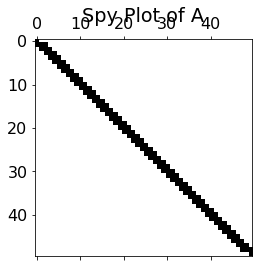

In [10]:
plt.spy(A.toarray())
plt.title('Spy Plot of A')

In [11]:
B_lower_diag = alpha*np.ones(Nz)
B_lower_diag[-2] = 0

B_diag = (1 - 2*alpha)*np.ones(Nz)
B_diag[0] = 1
B_diag[-1] = 1

B_upper_diag = alpha*np.ones(Nz)
B_upper_diag[1] = 0

B_data = np.array(
	[
		B_lower_diag,
		B_diag,
		B_upper_diag
	]
)
B_offsets = np.array([-1, 0, 1])
B = sparseModule.dia_matrix((B_data, B_offsets), shape=(Nz, Nz))
B.toarray()

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.44386854, 0.11226292, 0.44386854, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.44386854, 0.11226292, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.11226292, 0.44386854,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.44386854, 0.11226292,
        0.44386854],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

Text(0.5, 1.05, 'Spy Plot of B')

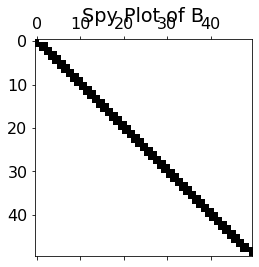

In [12]:
plt.spy(B.toarray())
plt.title('Spy Plot of B')

### 7. Preallocate Storage Memory

In [13]:
scenarios['1.5C']['temperature'] = np.zeros((Nz, Nt))
scenarios['3.0C']['temperature'] = np.zeros((Nz, Nt))
scenarios['4.5C']['temperature'] = np.zeros((Nz, Nt))

### 8. Apply Solution And Compute Temperatures

In [14]:
# Print summary of simulation information
print('--- Simulation Parameters ---')
print('Spatial Domain')
print('  z_top =     {:<8.2f} [m]'.format(scenarios['sim_data']['z_top']))
print('  z_bottom =  {:<8.2f} [m]'.format(scenarios['sim_data']['z_bottom']))
print('  Nz =        {:<8d}'.format(scenarios['sim_data']['Nz']))
print('  dz =        {:<8.2f} [m]'.format(scenarios['sim_data']['dz']))
print('Temporal Domain')
print('  t_initial = {:<8.2f} [s]'.format(scenarios['sim_data']['t_initial']))
print('  t_final =   {:<8.2f} [s]'.format(scenarios['sim_data']['t_final']))
print('  Nt =        {:<8d}'.format(scenarios['sim_data']['Nt']))
print('  dt =        {:<8.2f} [s]'.format(scenarios['sim_data']['dt']))

--- Simulation Parameters ---
Spatial Domain
  z_top =     0.00     [m]
  z_bottom =  5.00     [m]
  Nz =        50      
  dz =        0.10     [m]
Temporal Domain
  t_initial = 2020.00  [s]
  t_final =   2100.00  [s]
  Nt =        116879  
  dt =        21600.00 [s]


In [15]:
# Precompute inverse of A time B
Ainv_times_B = sparseModule.linalg.inv(A) @ B

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [16]:
for scenario in [scenarios['1.5C'], scenarios['3.0C'], scenarios['4.5C']]:

	for n in range(Nt):

		if n == 0:
			# Apply initial condition
			scenario['temperature'][:,n] = scenario['T_initial']

		else:
			# Time step
			scenario['temperature'][:,n] = Ainv_times_B @ scenario['temperature'][:, n-1]

			# Apply boundary condition
			scenario['temperature'][0,n] = scenario['top_BC_data'][n]
			scenario['temperature'][-1,n] = scenario['bottom_BC_data']
		

### 9. Plot Results, Analyze, and Interpret

Create plots of the following:

1. A plot of 3 x 2 subplots of the vertical temperature distribution with time. Each row should correspond to each of the 3 climate change scenarios wiht the top row being the $\Delta T = 1.5{}^{\circ}C$, the middle being $\Delta T = 3.0{}^{\circ}C$, and the bottom row being $\Delta T = 4.5{}^{\circ}C$. The left column should correspond to the ___first___ 10 years of simulation, and the right column the ___last___ 10 years of simulation.
2. A plot of 2 x 2 subplots of the temperature at four different levels. One subplot of temperature versus time for all three scenarios at a depth of 50 cm, the second subplot the same information at 100 cm, the third subplot the same information at 200 cm, and the fourth subplot the same information at 400 cm. 
3. A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.  

### Plot Number 1

 A plot of 3 x 2 subplots of the vertical temperature distribution with time. Each row should correspond to each of the 3 climate change scenarios wiht the top row being the $\Delta T = 1.5{}^{\circ}C$, the middle being $\Delta T = 3.0{}^{\circ}C$, and the bottom row being $\Delta T = 4.5{}^{\circ}C$. The left column should correspond to the ___first___ 10 years of simulation, and the right column the ___last___ 10 years of simulation.

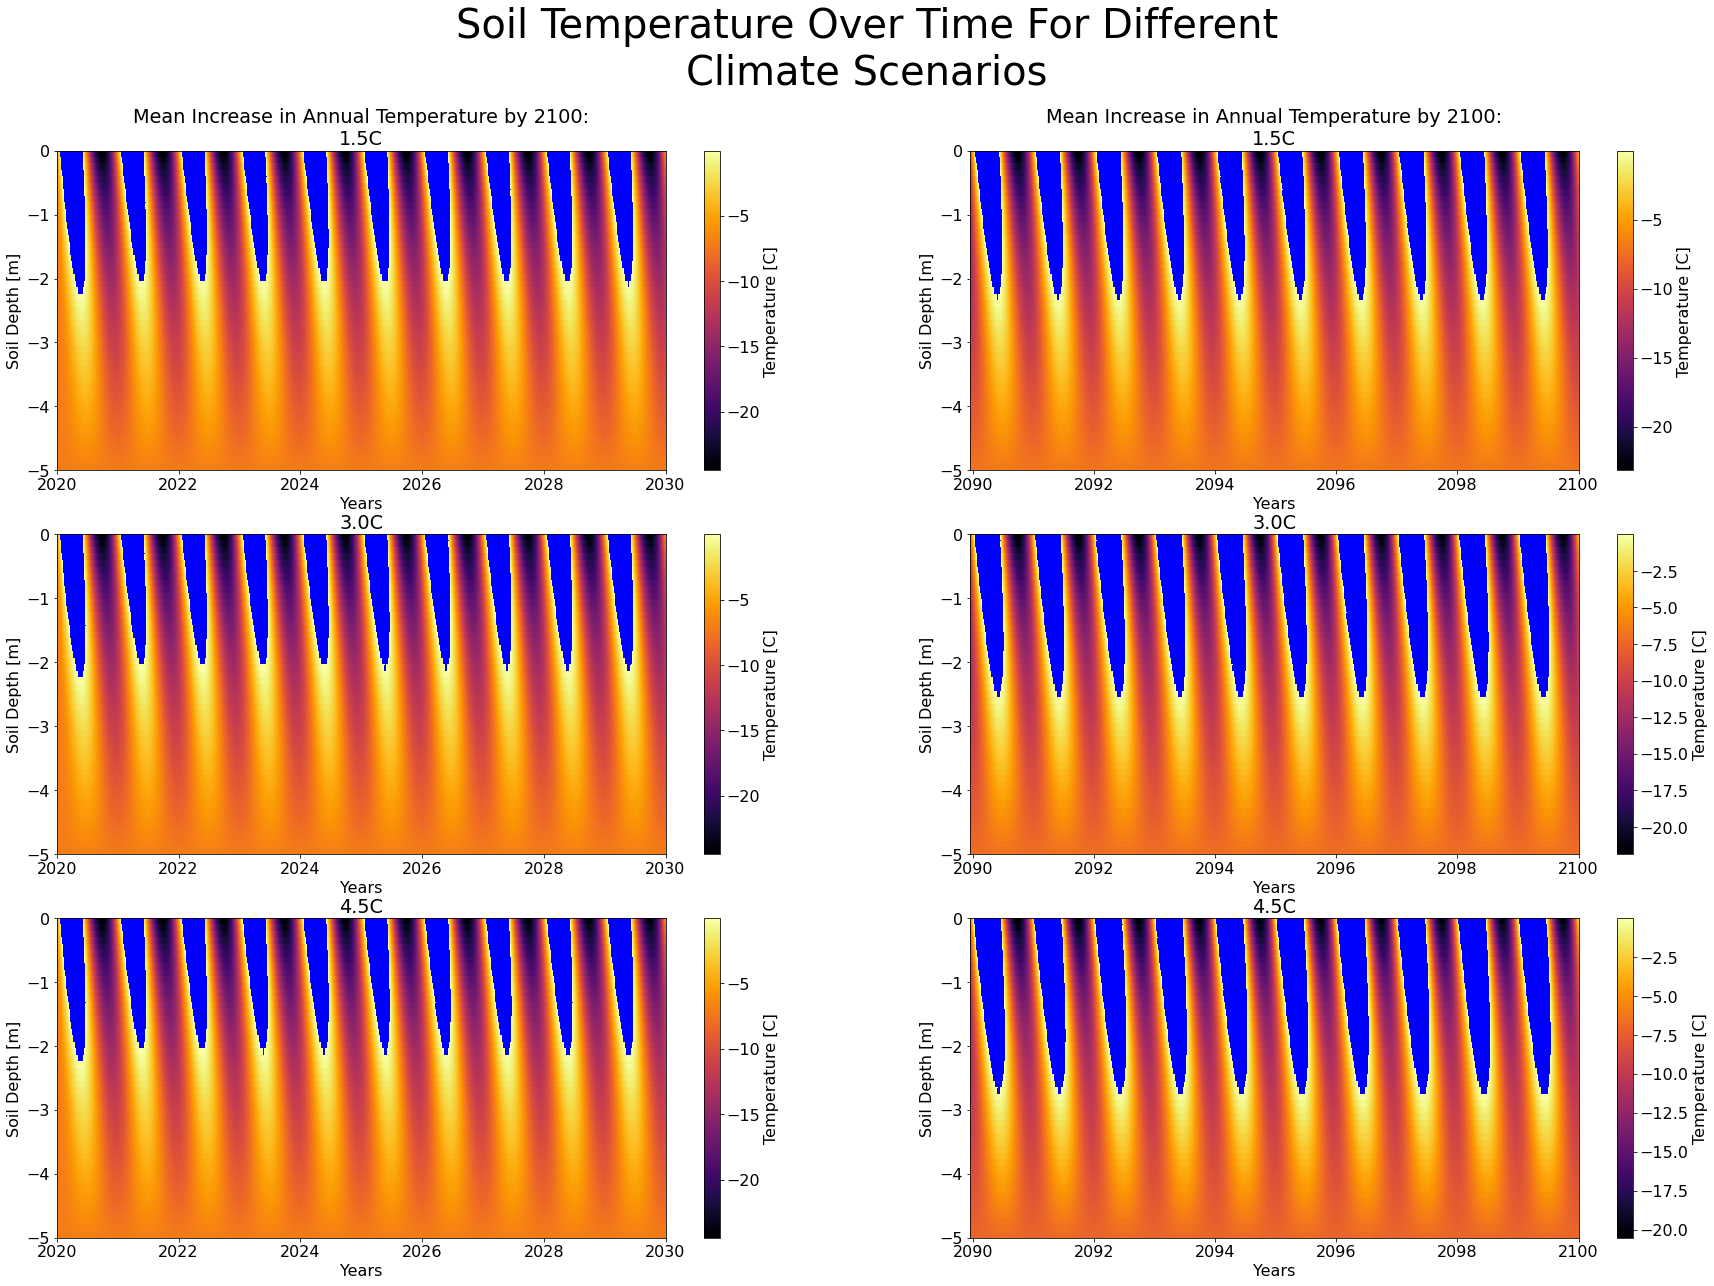

In [17]:
scenario_names = [
	'1.5C',
	'3.0C',
	'4.5C'
]

fig, axes = plt.subplots(3, 2, figsize=(30,20))
fig.suptitle('Soil Temperature Over Time For Different\nClimate Scenarios', size=40)

for iplt in range(3):
	# Get scenario
	scenario_name = scenario_names[iplt]
	scenario = scenarios[scenario_name]
	T = scenario['temperature'] # Temperature [C], (z, t)

	cmap = plt.cm.get_cmap('inferno')
	cmap.set_bad(color='blue')

	# First 10 years (2020 - 2030)
	beginning = 0
	first_10_years = 4*365*10

	subplot = axes[iplt, 0]

	T_frozen = np.ma.masked_where(T>0.0, T)
	tt, zz = np.meshgrid(scenarios['sim_data']['time_steps'][beginning:first_10_years], scenarios['sim_data']['z_data'])
	im = subplot.pcolormesh(tt, -zz, T_frozen[:,beginning:first_10_years], cmap=cmap)
	
	if iplt == 0:
		subplot.set_title('Mean Increase in Annual Temperature by 2100:\n{}'.format(scenario_name))
	else:
		subplot.set_title(scenario_name)
	subplot.set_xlabel('Years')
	subplot.set_xticks(np.arange(2020, 2032, 2))
	subplot.set_ylabel('Soil Depth [m]')

	cbar = fig.colorbar(im, ax=subplot)
	cbar.set_label('Temperature [C]')
	
	# Last 10 years (2090 - 2100)
	last_10_years = 4*365*(2090 - 2020)
	end = -1

	subplot = axes[iplt, 1]

	tt, zz = np.meshgrid(scenarios['sim_data']['time_steps'][last_10_years:end], scenarios['sim_data']['z_data'])
	im = subplot.pcolormesh(tt, -zz, T_frozen[:,last_10_years:end], cmap=cmap)

	if iplt == 0:
		subplot.set_title('Mean Increase in Annual Temperature by 2100:\n{}'.format(scenario_name))
	else:
		subplot.set_title(scenario_name)
	subplot.set_xlabel('Years')
	subplot.set_xticks(np.arange(2090, 2102, 2))
	subplot.set_ylabel('Soil Depth [m]')
	
	cbar = fig.colorbar(im, ax=subplot)
	cbar.set_label('Temperature [C]')

plt.savefig('assets/plt1-soil_temps_over_time_scenarios.png')


### Plot Number 2

A plot of 2 x 2 subplots of the temperature at four different levels. One subplot of temperature versus time for all three scenarios at a depth of 50 cm, the second subplot the same information at 100 cm, the third subplot the same information at 200 cm, and the fourth subplot the same information at 400 cm. 

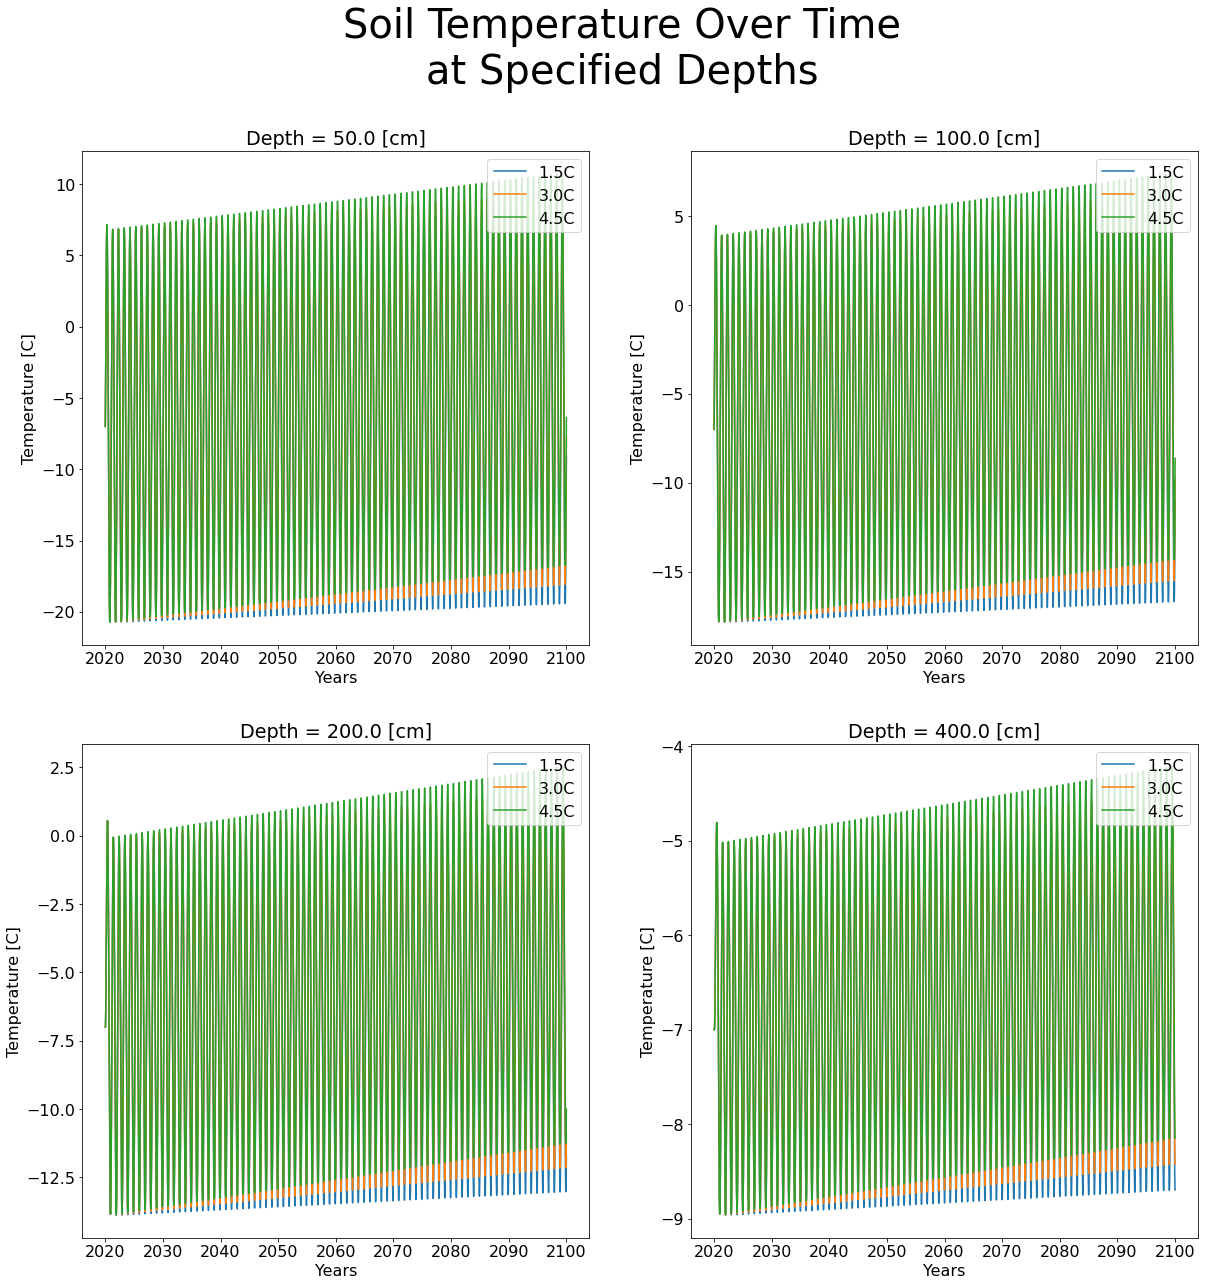

In [18]:
depths = np.array([
	0.5, 1.0, 2.0, 4.0 # [m]
])
depth_indices = np.array([np.ceil(depth / scenarios['sim_data']['dz']) for depth in depths], dtype=int)

labels = ['Depth = {} [cm]'.format(depth * 100) for depth in depths]

fig, axes = plt.subplots(2, 2, figsize=(20,20))
fig.suptitle('Soil Temperature Over Time\nat Specified Depths', size=40)



for iplt in range(2):
	for jplt in range(2):
		nplt = jplt + iplt*2
		
		subplot = axes[iplt, jplt]
		depth_index = depth_indices[nplt]

		for nn, scenario in enumerate([scenarios['1.5C'], scenarios['3.0C'], scenarios['4.5C']]):
			scenario_name = scenario_names[nn]
			subplot.plot(scenarios['sim_data']['time_steps'], scenario['temperature'][depth_index,:], label=scenario_name)
			subplot.legend(loc='upper right')

		subplot.set_title(labels[nplt])
		subplot.set_xlabel('Years')
		subplot.set_ylabel('Temperature [C]')

plt.savefig('assets/plt2-soil_temps_at_depths.png')


### Plot Number 3

A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.  

In [19]:
active_layer_threshold = 0 # [C]
first_decade_index = 4*365*10
middle_decade_index = 4*365*40
final_decade_index = -1

def findActiveLayer(z, T):
	# Given a 1D array of z (soil depth) and T (temperature), find the active layer (depth where T == 0)
	dz = z[1] - z[0]
	return dz * len(T[np.where(T > 0)])

In [20]:
active_layers = np.zeros((3,3)) # (scenario, decade)
ranges = [
	(0, 4*365*10),
	(4*365*30, 4*365*40),
	(4*365*70, 4*365*80)
]

z = scenarios['sim_data']['z_data']

for i, scenario in enumerate([scenarios['1.5C'], scenarios['3.0C'], scenarios['4.5C']]):
	for j, decade_range in enumerate(ranges):
		for time_index in range(decade_range[0], decade_range[1]):
			T = scenario['temperature'][:,time_index]
			active_layers[i, j] = max(active_layers[i, j], findActiveLayer(z, T))

In [21]:
# Some nifty code that will create a Markdown table string from some Python data
# Becuase, you know, if you have a problem, someone has probably already solved it in Python on Stack Overflow...
# Source: https://stackoverflow.com/questions/13394140/generate-markdown-tables

# Translation dictionaries for table alignment
left_rule = {'<': ':', '^': ':', '>': '-'}
right_rule = {'<': '-', '^': ':', '>': ':'}

def evalute_field(record, field_spec):
    """
    Evalute a field of a record using the type of the field_spec as a guide.
    """
    if type(field_spec) is int:
        return str(record[field_spec])
    elif type(field_spec) is str:
        return str(getattr(record, field_spec))
    else:
        return str(field_spec(record))

def table(file, records, fields, headings, alignment = None):
    """
    Generate a Doxygen-flavor Markdown table from records.

    file -- Any object with a 'write' method that takes a single string
        parameter.
    records -- Iterable.  Rows will be generated from this.
    fields -- List of fields for each row.  Each entry may be an integer,
        string or a function.  If the entry is an integer, it is assumed to be
        an index of each record.  If the entry is a string, it is assumed to be
        a field of each record.  If the entry is a function, it is called with
        the record and its return value is taken as the value of the field.
    headings -- List of column headings.
    alignment - List of pairs alignment characters.  The first of the pair
        specifies the alignment of the header, (Doxygen won't respect this, but
        it might look good, the second specifies the alignment of the cells in
        the column.

        Possible alignment characters are:
            '<' = Left align (default for cells)
            '>' = Right align
            '^' = Center (default for column headings)
    """

    num_columns = len(fields)
    assert len(headings) == num_columns

    # Compute the table cell data
    columns = [[] for i in range(num_columns)]
    for record in records:
        for i, field in enumerate(fields):
            columns[i].append(evalute_field(record, field))

    # Fill out any missing alignment characters.
    extended_align = alignment if alignment != None else []
    if len(extended_align) > num_columns:
        extended_align = extended_align[0:num_columns]
    elif len(extended_align) < num_columns:
        extended_align += [('^', '<')
                           for i in range[num_columns-len(extended_align)]]

    heading_align, cell_align = [x for x in zip(*extended_align)]

    field_widths = [len(max(column, key=len)) if len(column) > 0 else 0
                    for column in columns]
    heading_widths = [max(len(head), 2) for head in headings]
    column_widths = [max(x) for x in zip(field_widths, heading_widths)]

    _ = ' | '.join(['{:' + a + str(w) + '}'
                    for a, w in zip(heading_align, column_widths)])
    heading_template = '| ' + _ + ' |'
    _ = ' | '.join(['{:' + a + str(w) + '}'
                    for a, w in zip(cell_align, column_widths)])
    row_template = '| ' + _ + ' |'

    _ = ' | '.join([left_rule[a] + '-'*(w-2) + right_rule[a]
                    for a, w in zip(cell_align, column_widths)])
    ruling = '| ' + _ + ' |'

    file.write(heading_template.format(*headings).rstrip() + '\n')
    file.write(ruling.rstrip() + '\n')
    for row in zip(*columns):
        file.write(row_template.format(*row).rstrip() + '\n')

In [22]:
headings = ['Scenario', '2020 - 2030', '2050 - 2060', '2090 - 2100']
data = [
	('1.5C Increase', '{:.4f}'.format(active_layers[0,0]), '{:.4f}'.format(active_layers[0,1]), '{:.4f}'.format(active_layers[0,2])),
	('3.0C Increase', '{:.4f}'.format(active_layers[1,0]), '{:.4f}'.format(active_layers[1,1]), '{:.4f}'.format(active_layers[1,2])),
	('4.5C Increase', '{:.4f}'.format(active_layers[2,0]), '{:.4f}'.format(active_layers[2,1]), '{:.4f}'.format(active_layers[2,2])),
]
fields = [i for i in range(4)]
align = [
	('^', '<'),
	('^', '<'),
	('^', '<'),
	('^', '<')
]
table(sys.stdout, data, fields, headings, alignment=align)

|   Scenario    | 2020 - 2030 | 2050 - 2060 | 2090 - 2100 |
| :------------ | :---------- | :---------- | :---------- |
| 1.5C Increase | 2.2449      | 2.2449      | 2.3469      |
| 3.0C Increase | 2.2449      | 2.3469      | 2.5510      |
| 4.5C Increase | 2.2449      | 2.4490      | 2.7551      |


Below is a table of the computed active layer for three different decades in the simulation for all three temperature increase scenarios:

|   Scenario    | 2020 - 2030 | 2050 - 2060 | 2090 - 2100 |
| :------------ | :---------- | :---------- | :---------- |
| 1.5C Increase | 2.2449      | 2.2449      | 2.3469      |
| 3.0C Increase | 2.2449      | 2.3469      | 2.5510      |
| 4.5C Increase | 2.2449      | 2.4490      | 2.7551      |